## KMeans Clustering -- EDA, JVA & Kinect

The clustering analysis below explores how motor sensors used in the MMLA study predict qualitative, collaborative outcomes. Measures used are as follows:
1. EDA: Directional Agreement, Signal Matching, Pearsons' Correlations, Instantaneous Directional Matching
2. JVA: number of jva100 counts per second
3. Kinect: difference in total movements between dyads

Clustering analysis was performed by combining each EDA measure with JVA and Kinect, the resulting analyses were:

1. DA+JVA+Kinect
2. SM+JVA+Kinect
3. PC+JVA+Kinect
4. IDM+JVA+Kinect

In [1]:
#import packages for clustering
import os
import math
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#generate master file for clustering
master = []
directory = os.getcwd() #get directory path
for csv in os.listdir(directory):
    if "_combinewKinect_bySecond.csv" in csv:  
        file = pd.read_csv(csv, index_col='Unnamed: 0')
        cols = ['session','second_x','DA','PC','IDM','SM','jva100','JVA',
                'movement_total_L','movement_total_R']
        fileNew = file.loc[:, cols]
        cols_fillnan = ['DA','PC','IDM','SM','jva100','JVA',
                        'movement_total_L','movement_total_R']
        fileNew[cols_fillnan] = fileNew[cols_fillnan].fillna(fileNew[cols_fillnan].mean(skipna=True)) #fill nans with mean for clustering purposes
        #compute difference in movement and append to data frame
        fileNew['moveDiff'] = abs(fileNew['movement_total_L'] - fileNew['movement_total_R'])
        fileNew = fileNew.rename(columns = {'second_x':'second'}) #rename 'second' column
        master.append(fileNew)

In [3]:
dfMaster = pd.concat(master, axis = 0) #concatenate data frames for master file

In [4]:
dfMaster.shape #check shape of master file

(1491855, 11)

In [5]:
dfMaster = dfMaster.fillna(dfMaster.mean(skipna = True))

In [6]:
#aggregate data
dfMaster = dfMaster.groupby(['session','second']).agg({
    'DA': np.mean,
    'PC': np.mean,
    'IDM': np.mean,
    'SM': np.mean,
    'jva100': np.mean,
    'moveDiff': np.mean
})

In [7]:
dfMaster = dfMaster.reset_index().reset_index()
dfMaster.head()

,index,session,second,DA,PC,IDM,SM,jva100,moveDiff
0,0,2,1,0.233333,-0.447563,0.177397,0.208709,24.0,1.941329
1,1,2,2,0.232708,-0.445837,0.177548,0.207804,7.0,2.013969
2,2,2,3,0.233125,-0.442000,0.177468,0.206289,18.0,1.825878
3,3,2,4,0.234583,-0.439776,0.176532,0.205172,23.0,1.675585
4,4,2,5,0.234375,-0.438995,0.175948,0.204015,6.0,1.967405


**Optimal K by Distortion Rate**

In [8]:
scaleCols = ['DA','PC','IDM','SM','jva100','moveDiff'] #scale columns for clustering
scaler = StandardScaler()
scaler.fit(dfMaster[scaleCols])
dfMaster_scaled = dfMaster.copy() #copy original master data frame
dfMaster_scaled = dfMaster_scaled.loc[:, scaleCols]
dfMaster_scaled[scaleCols] = scaler.transform(dfMaster_scaled[scaleCols]) #scale transform cluster columns
dfMaster_scaled['index'] = np.arange(len(dfMaster_scaled)) #reappend index column to dfMaster_scaled for merging
dfMaster_scaled = dfMaster_scaled.rename(columns = {'DA':'DA_scaled', 'SM':'SM_scaled', 
                                                    'PC':'PC_scaled','IDM': 'IDM_scaled',
                                                    'jva100':'jva100_scaled',
                                                    'moveDiff': 'moveDiff_scaled'})
dfMaster = dfMaster.merge(dfMaster_scaled, on = 'index', how = 'outer') #merge scaled data with original data

In [ ]:
#find optimal number of clustering for KMeans
distortionPC = list() #cache list for distortion value
for n in range(1,11): #fit number of clusters in the range of 1 to 10
    kmeans_pc = KMeans(n_clusters=n, random_state=11)
    kmeans_pc.fit(dfMaster.loc[:, ['PC_scaled','jva100_scaled','moveDiff_scaled']]) 
    distortionPC.append(kmeans_pc.inertia_) #append distortion value to list

distortionDA = list()
for n in range(1,11):
    kmeans_da = KMeans(n_clusters=n, random_state=11)
    kmeans_da.fit(dfMaster.loc[:, ['DA_scaled','jva100_scaled','moveDiff_scaled']])
    distortionDA.append(kmeans_da.inertia_)
    
distortionSM = list()
for n in range(1,11):
    kmeans_sm = KMeans(n_clusters=n, random_state=11)
    kmeans_sm.fit(dfMaster.loc[:, ['SM_scaled','jva100_scaled','moveDiff_scaled']])
    distortionSM.append(kmeans_sm.inertia_)
    
distortionIDM = list()
for n in range(1,11):
    kmeans_idm = KMeans(n_clusters=n, random_state=11)
    kmeans_idm.fit(dfMaster.loc[:, ['IDM_scaled','jva100_scaled','moveDiff_scaled']])
    distortionIDM.append(kmeans_idm.inertia_)

#plot elbow curves 
fig = plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), distortionPC, c = 'b', label = 'PC+JVA+Kinect')
plt.plot(range(1, 11), distortionDA, c = 'g', label = 'DA+JVA+Kinect')
plt.plot(range(1, 11), distortionSM, c = 'r', label = 'SM+JVA+Kinect')
plt.plot(range(1, 11), distortionIDM, c = 'y', label = 'IDMM+JVA+Kinect')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.legend()
plt.grid(True)
plt.title('Elbow curve')
plt.show()

**PC+JVA+Kinect**

In [75]:
%%file cluster.py
import math
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

def makeCluster(df, n, rs, cols):
    '''
    Parameters:
    1) df: master data frame
    2) n: number of clusters
    3) rs: random state
    4) cols: list of clustering variables
    '''
    #copy dataframe
    dfCluster = df.copy()

    #fit clusters
    kmeans = KMeans(n_clusters = n, random_state = rs)
    kmeans.fit(dfCluster.loc[:, cols])

    #get location of cluster centroids and label
    center = kmeans.cluster_centers_
    label = kmeans.labels_
    dfCluster['cluster_label'] = label

    #append centroids to data frame
    for a in range(len(center)):
        for b in range(len(center[0])):
            dfCluster['c'+ str(a) + cols[b]] = center[a][b]        

    #compute distance to centroids
    distances = defaultdict(list)
    for c in range(len(center)):
        for d in range(len(cols)):
            distances['c'+str(c)+'distance'].append(abs(dfCluster[cols[d]]
                                                        - dfCluster['c'+str(c)+cols[d]]))

    #append distance to centroids to data frame
    for key in distances:
        dfCluster[key] = sum(distances[key])

    #record points closest to centroids
    centroids = defaultdict(list)
    for e in range(len(center)):
        centroids['c'+str(e)].append(dfCluster[dfCluster['c'+str(e)+'distance']
                                               == dfCluster['c'+str(e)+'distance'].min()])

    return dfCluster, centroids

def visualizeCluster(df, n, cols1, cols2):
    '''
    Parameters:
    1) df: dfCluster output by makeCluster()
    2) n: number of clusters
    3) cols1: list of scaled columns
    4) cols2: list of original columns (len(cols2) == len(cols1))
    '''
    dfList = list() #cache list for data frames by cluster labels
    plot = defaultdict(list) #cache dictionary for plots
    for i in range(n):
        dfList.append(df[df['cluster_label'] == i])
        plot['clusters'].append('cluster'+str(i+1))

    for data in dfList:
        for a in range(len(cols1)):
            plot[cols1[a]].append(data[cols1[a]].mean())
            plot[cols2[a]].append(data[cols2[a]].mean())
    
    #convert to data frame
    dfPlot = pd.DataFrame.from_dict(plot)

    items = plot['clusters']
    
    options = ['r','g','b','y','purple','grey','pink','black']
    colors = np.random.choice(options, n, replace = False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))
    for i in range(len(dfPlot)):
        ax1.scatter(range(len(cols1)), dfPlot[dfPlot['clusters'] == items[i]][cols1].values.reshape(-1,1), color = colors[i], label = items[i], alpha = 0.5)
    for i in range(len(dfPlot)):
        ax2.scatter(range(len(cols2)), dfPlot[dfPlot['clusters'] == items[i]][cols2].values.reshape(-1,1), color = colors[i], label = items[i], alpha = 0.5)
    ax1.set_xticks(range(0, len(cols1), 1))
    ax2.set_xticks(range(0, len(cols2), 1))
    ax1.set_xticklabels(labels = cols1)
    ax2.set_xticklabels(labels = cols2)
    ax1.legend()
    ax2.legend()
    plt.show()

def removeMissingData(a, b):
    """ takes in two lists and removes rows with missing data """
    x = list(a)
    y = list(b)
    i = len(x) -1
    while(i != -1):  # get rid of missing values
        if x[i] == None or y[i] == None \
        or math.isnan(x[i]) or math.isnan(y[i]):
            del x[i]; del y[i]
        i -= 1
    return (x,y)

def calculate_pvalues(df):
    """ computes the p-value for each correlation """
    #df = df.dropna()._get_numeric_data()
    df = df._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            x,y = removeMissingData(df[r],df[c])
            results = stats.pearsonr(x,y)
            pvalues[r][c] = round(results[1], 4)
            #pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

Overwriting cluster.py


In [76]:
dfMaster_pc, centroids_pc = makeCluster(dfMaster, 4, 11, ['PC_scaled','jva100_scaled','moveDiff_scaled'])

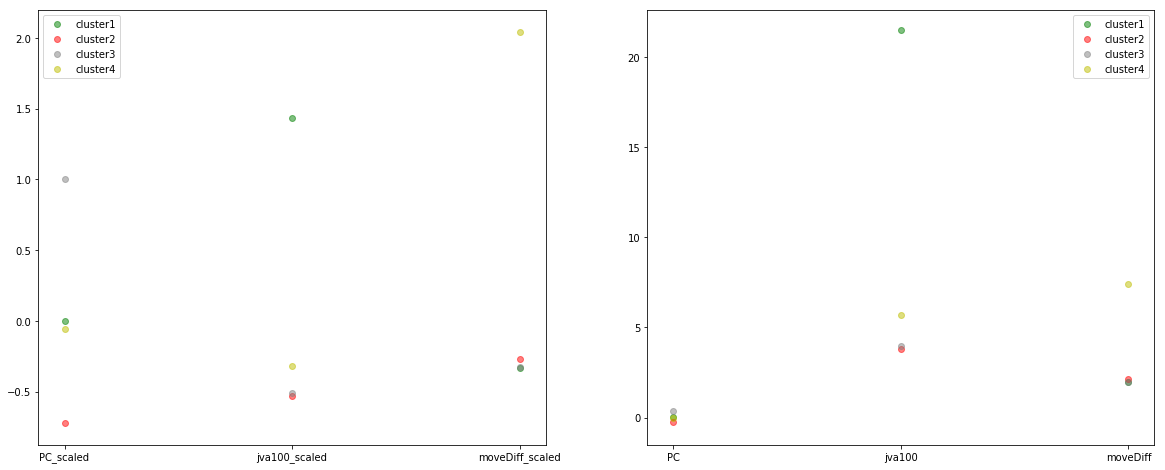

In [77]:
visualizeCluster(dfMaster_pc, 4, ['PC_scaled','jva100_scaled','moveDiff_scaled'],['PC','jva100','moveDiff'])

In [56]:
dfMaster_pc = dfMaster.copy()

#fit clusters 
kmeans_pc = KMeans(n_clusters=4, random_state = 11)
kmeans_pc.fit(dfMaster_pc.loc[:, ['PC_scaled','jva100_scaled','moveDiff_scaled']])
#get location of clusters center and label
center_pc = kmeans_pc.cluster_centers_
label_pc = kmeans_pc.labels_
dfMaster_pc['cluster_pc'] = label_pc #append cluster column
dfMaster_pc['c1_pc'] = center_pc[0][0]
dfMaster_pc['c1_jva'] = center_pc[0][1]
dfMaster_pc['c1_mot'] = center_pc[0][2]

dfMaster_pc['c2_pc'] = center_pc[1][0]
dfMaster_pc['c2_jva'] = center_pc[1][1]
dfMaster_pc['c2_mot'] = center_pc[1][2]

dfMaster_pc['c3_pc'] = center_pc[2][0]
dfMaster_pc['c3_jva'] = center_pc[2][1]
dfMaster_pc['c3_mot'] = center_pc[2][2]

dfMaster_pc['c4_pc'] = center_pc[3][0]
dfMaster_pc['c4_jva'] = center_pc[3][1]
dfMaster_pc['c4_mot'] = center_pc[3][2]

#calculate distance from centroids to find closest point to centroids
dfMaster_pc['c1_distance'] = (abs(dfMaster_pc['PC_scaled']-dfMaster_pc['c1_pc']) 
                              + abs(dfMaster_pc['jva100_scaled']-dfMaster_pc['c1_jva'])
                              + abs(dfMaster_pc['moveDiff_scaled']-dfMaster_pc['c1_mot']))
dfMaster_pc['c2_distance'] = (abs(dfMaster_pc['PC_scaled']-dfMaster_pc['c2_pc']) 
                              + abs(dfMaster_pc['jva100_scaled']-dfMaster_pc['c2_jva'])
                              + abs(dfMaster_pc['moveDiff_scaled']-dfMaster_pc['c2_mot']))
dfMaster_pc['c3_distance'] = (abs(dfMaster_pc['PC_scaled']-dfMaster_pc['c3_pc']) 
                              + abs(dfMaster_pc['jva100_scaled']-dfMaster_pc['c3_jva'])
                              + abs(dfMaster_pc['moveDiff_scaled']-dfMaster_pc['c3_mot']))
dfMaster_pc['c4_distance'] = (abs(dfMaster_pc['PC_scaled']-dfMaster_pc['c4_pc']) 
                              + abs(dfMaster_pc['jva100_scaled']-dfMaster_pc['c4_jva'])
                              + abs(dfMaster_pc['moveDiff_scaled']-dfMaster_pc['c4_mot']))

#output points closest to centroids
c1 = dfMaster_pc[dfMaster_pc['c1_distance'] == dfMaster_pc['c1_distance'].min()]
c2 = dfMaster_pc[dfMaster_pc['c2_distance'] == dfMaster_pc['c2_distance'].min()]
c3 = dfMaster_pc[dfMaster_pc['c3_distance'] == dfMaster_pc['c3_distance'].min()]
c4 = dfMaster_pc[dfMaster_pc['c4_distance'] == dfMaster_pc['c4_distance'].min()]

In [57]:
cluster1_pc = dfMaster_pc[dfMaster_pc['cluster_pc'] == 0]
cluster2_pc = dfMaster_pc[dfMaster_pc['cluster_pc'] == 1]
cluster3_pc = dfMaster_pc[dfMaster_pc['cluster_pc'] == 2]
cluster4_pc = dfMaster_pc[dfMaster_pc['cluster_pc'] == 3]

In [ ]:
plot_pc = defaultdict(list)
for item in ['cluster1','cluster2','cluster3','cluster4']:
    plot_pc['clusters'].append(item)

dfList = [cluster1_pc, cluster2_pc, cluster3_pc, cluster4_pc]
for df in dfList:
    plot_pc['PC_scaled'].append(df['PC_scaled'].mean())
    plot_pc['jva100_scaled'].append(df['jva100_scaled'].mean()) 
    plot_pc['moveDiff_scaled'].append(df['moveDiff_scaled'].mean())

    plot_pc['PC'].append(df['PC'].mean())
    plot_pc['jva100'].append(df['jva100'].mean()) 
    plot_pc['moveDiff'].append(df['moveDiff'].mean())

dfPlot_pc = pd.DataFrame.from_dict(plot_pc)

In [ ]:
dfPlot_pc

In [ ]:
pc_scaled = ['PC_scaled', 'jva100_scaled', 'moveDiff_scaled']
pc = ['PC', 'jva100', 'moveDiff']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))
ax1.scatter(range(3), dfPlot_pc[dfPlot_pc['clusters']=='cluster1'][pc_scaled].values.reshape(-1,1), color = 'red', label = 'cluster1')
ax1.scatter(range(3), dfPlot_pc[dfPlot_pc['clusters']=='cluster2'][pc_scaled].values.reshape(-1,1), color = 'blue', label = 'cluster2')
ax1.scatter(range(3), dfPlot_pc[dfPlot_pc['clusters']=='cluster3'][pc_scaled].values.reshape(-1,1), color = 'green', label = 'cluster3')
ax1.scatter(range(3), dfPlot_pc[dfPlot_pc['clusters']=='cluster4'][pc_scaled].values.reshape(-1,1), color = 'grey', label = 'cluster4')
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(labels = pc_scaled)
ax1.legend()

ax2.scatter(range(3), dfPlot_pc[dfPlot_pc['clusters']=='cluster1'][pc].values.reshape(-1,1), color = 'red', label = 'cluster1')
ax2.scatter(range(3), dfPlot_pc[dfPlot_pc['clusters']=='cluster2'][pc].values.reshape(-1,1), color = 'blue', label = 'cluster2')
ax2.scatter(range(3), dfPlot_pc[dfPlot_pc['clusters']=='cluster3'][pc].values.reshape(-1,1), color = 'green', label = 'cluster3')
ax2.scatter(range(3), dfPlot_pc[dfPlot_pc['clusters']=='cluster4'][pc].values.reshape(-1,1), color = 'grey', label = 'cluster4')
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(labels = pc)
ax2.legend()

plt.show()

In [ ]:
timeCluster_pc = pd.DataFrame(dfMaster_pc.groupby(['session', 'cluster_pc'])['index'].count()).reset_index().reset_index()

In [ ]:
timeCluster_pc = timeCluster_pc.pivot(index='session', columns='cluster_pc', values='index').reset_index().rename(columns = 
                                                                                        {0:'timeCluster1',
                                                                                         1:'timeCluster2',
                                                                                         2:'timeCluster3',
                                                                                         3:'timeCluster4',
                                                                                         'session': 'Session'})

In [ ]:
timeCluster_pc = timeCluster_pc.loc[:, 'Session':'timeCluster4']

In [ ]:
sessions = pd.read_csv('sessions.csv')
sessions = sessions.merge(timeCluster_pc, on = 'Session', how = 'outer') #merge data frames for correlation

dependent = ['Sustaining Mutual Understanding ', 'Dialogue Management',
             'Information Pooling', 'Reaching Consensus', 'Task Division',
             'Time Managment', 'Technical Coordination', 'Reciprocal Interaction',
             'Individual Task Orientation', 'Collaboration', 'Task Performance',
             'Task Understanding', 'Improvement Over Time', 'Code quality',
             'Learning']
time_pc = ['timeCluster1','timeCluster2','timeCluster3','timeCluster4']

correlations_pc = sessions.corr()
ax = sns.heatmap(correlations_pc.loc[dependent][time_pc], annot=True)

In [ ]:
def removeMissingData(a, b):
    """ takes in two lists and removes rows with missing data """
    x = list(a)
    y = list(b)
    i = len(x) -1
    while(i != -1):  # get rid of missing values
        if x[i] == None or y[i] == None \
        or math.isnan(x[i]) or math.isnan(y[i]):
            del x[i]; del y[i]
        i -= 1
    return (x,y)

def calculate_pvalues(df):
    """ computes the p-value for each correlation """
    #df = df.dropna()._get_numeric_data()
    df = df._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            x,y = removeMissingData(df[r],df[c])
            results = stats.pearsonr(x,y)
            pvalues[r][c] = round(results[1], 4)
            #pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [ ]:
pvalues_pc = calculate_pvalues(sessions).astype(float)
ax = sns.heatmap(pvalues_pc.loc[dependent][time_pc], annot=True)

The heatmap above indicates that there is a significant correlation between 1) time spent in cluster 1 and sustaining mutual understanding (p = 0.018), and 2) time spent in cluster 3 and sustaining mutual understanding (p = 0.012) dialogue management (p = 0.015). 

Cluster 1: 
1. Highest jva100 count
2. Second-Highest scaled PC
3. Least movement difference

Cluster 3:
1. Highest scaled PC
2. Second-Lowest jva100 count
3. Second-Least movement difference

**DA+JVA+Kinect**

In [ ]:
dfMaster_da = dfMaster.copy()

#fit clusters 
kmeans_da = KMeans(n_clusters=4, random_state = 11)
kmeans_da.fit(dfMaster_da.loc[:, ['DA_scaled','jva100_scaled','moveDiff_scaled']])
#get location of clusters center and label
center_da = kmeans_da.cluster_centers_
label_da = kmeans_da.labels_
dfMaster_da['cluster_da'] = label_da #append cluster column
dfMaster_da['c1_da'] = center_da[0][0]
dfMaster_da['c1_jva'] = center_da[0][1]
dfMaster_da['c1_mot'] = center_da[0][2]

dfMaster_da['c2_da'] = center_da[1][0]
dfMaster_da['c2_jva'] = center_da[1][1]
dfMaster_da['c2_mot'] = center_da[1][2]

dfMaster_da['c3_da'] = center_da[2][0]
dfMaster_da['c3_jva'] = center_da[2][1]
dfMaster_da['c3_mot'] = center_da[2][2]

dfMaster_da['c4_da'] = center_da[3][0]
dfMaster_da['c4_jva'] = center_da[3][1]
dfMaster_da['c4_mot'] = center_da[3][2]

#calculate distance from centroids to find closest point to centroids
dfMaster_da['c1_distance'] = (abs(dfMaster_da['DA_scaled']-dfMaster_da['c1_da']) 
                              + abs(dfMaster_da['jva100_scaled']-dfMaster_da['c1_jva'])
                              + abs(dfMaster_da['moveDiff_scaled']-dfMaster_da['c1_mot']))
dfMaster_da['c2_distance'] = (abs(dfMaster_da['DA_scaled']-dfMaster_da['c2_da']) 
                              + abs(dfMaster_da['jva100_scaled']-dfMaster_da['c2_jva'])
                              + abs(dfMaster_da['moveDiff_scaled']-dfMaster_da['c2_mot']))
dfMaster_da['c3_distance'] = (abs(dfMaster_da['DA_scaled']-dfMaster_da['c3_da']) 
                              + abs(dfMaster_da['jva100_scaled']-dfMaster_da['c3_jva'])
                              + abs(dfMaster_da['moveDiff_scaled']-dfMaster_da['c3_mot']))
dfMaster_da['c4_distance'] = (abs(dfMaster_da['DA_scaled']-dfMaster_da['c4_da']) 
                              + abs(dfMaster_da['jva100_scaled']-dfMaster_da['c4_jva'])
                              + abs(dfMaster_da['moveDiff_scaled']-dfMaster_da['c4_mot']))

#output points closest to centroids
c1 = dfMaster_da[dfMaster_da['c1_distance'] == dfMaster_da['c1_distance'].min()]
c2 = dfMaster_da[dfMaster_da['c2_distance'] == dfMaster_da['c2_distance'].min()]
c3 = dfMaster_da[dfMaster_da['c3_distance'] == dfMaster_da['c3_distance'].min()]
c4 = dfMaster_da[dfMaster_da['c4_distance'] == dfMaster_da['c4_distance'].min()]

In [ ]:
cluster1_da = dfMaster_da[dfMaster_da['cluster_da'] == 0]
cluster2_da = dfMaster_da[dfMaster_da['cluster_da'] == 1]
cluster3_da = dfMaster_da[dfMaster_da['cluster_da'] == 2]
cluster4_da = dfMaster_da[dfMaster_da['cluster_da'] == 3]

In [ ]:
plot_da = defaultdict(list)
for item in ['cluster1','cluster2','cluster3','cluster4']:
    plot_da['clusters'].append(item)

dfList_da = [cluster1_da, cluster2_da, cluster3_da, cluster4_da]
for df in dfList_da:
    plot_da['DA_scaled'].append(df['DA_scaled'].mean())
    plot_da['jva100_scaled'].append(df['jva100_scaled'].mean()) 
    plot_da['moveDiff_scaled'].append(df['moveDiff_scaled'].mean())

    plot_da['DA'].append(df['DA'].mean())
    plot_da['jva100'].append(df['jva100'].mean()) 
    plot_da['moveDiff'].append(df['moveDiff'].mean())

dfPlot_da = pd.DataFrame.from_dict(plot_da)

In [ ]:
da_scaled = ['DA_scaled', 'jva100_scaled', 'moveDiff_scaled']
da = ['DA', 'jva100', 'moveDiff']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))
ax1.scatter(range(3), dfPlot_da[dfPlot_da['clusters']=='cluster1'][da_scaled].values.reshape(-1,1), color = 'red', label = 'cluster1')
ax1.scatter(range(3), dfPlot_da[dfPlot_da['clusters']=='cluster2'][da_scaled].values.reshape(-1,1), color = 'blue', label = 'cluster2')
ax1.scatter(range(3), dfPlot_da[dfPlot_da['clusters']=='cluster3'][da_scaled].values.reshape(-1,1), color = 'green', label = 'cluster3')
ax1.scatter(range(3), dfPlot_da[dfPlot_da['clusters']=='cluster4'][da_scaled].values.reshape(-1,1), color = 'grey', label = 'cluster4')
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(labels = da_scaled)
ax1.legend()

ax2.scatter(range(3), dfPlot_da[dfPlot_da['clusters']=='cluster1'][da].values.reshape(-1,1), color = 'red', label = 'cluster1')
ax2.scatter(range(3), dfPlot_da[dfPlot_da['clusters']=='cluster2'][da].values.reshape(-1,1), color = 'blue', label = 'cluster2')
ax2.scatter(range(3), dfPlot_da[dfPlot_da['clusters']=='cluster3'][da].values.reshape(-1,1), color = 'green', label = 'cluster3')
ax2.scatter(range(3), dfPlot_da[dfPlot_da['clusters']=='cluster4'][da].values.reshape(-1,1), color = 'grey', label = 'cluster4')
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(labels = da)
ax2.legend()

plt.show()

In [ ]:
timeCluster_da = pd.DataFrame(dfMaster_da.groupby(['session', 'cluster_da'])['index'].count()).reset_index().reset_index()

timeCluster_da = timeCluster_da.pivot(index='session', columns='cluster_da', values='index').reset_index().rename(columns = 
                                                                                        {0:'timeCluster1',
                                                                                         1:'timeCluster2',
                                                                                         2:'timeCluster3',
                                                                                         3:'timeCluster4',
                                                                                         'session': 'Session'})

In [ ]:
sessions = pd.read_csv('sessions.csv')
sessions = sessions.merge(timeCluster_da, on = 'Session', how = 'outer') #merge data frames for correlation

dependent = ['Sustaining Mutual Understanding ', 'Dialogue Management',
             'Information Pooling', 'Reaching Consensus', 'Task Division',
             'Time Managment', 'Technical Coordination', 'Reciprocal Interaction',
             'Individual Task Orientation', 'Collaboration', 'Task Performance',
             'Task Understanding', 'Improvement Over Time', 'Code quality',
             'Learning']
time_da = ['timeCluster1','timeCluster2','timeCluster3','timeCluster4']

correlations_da = sessions.corr()
ax = sns.heatmap(correlations_da.loc[dependent][time_da], annot=True)

In [ ]:
pvalues_da = calculate_pvalues(sessions).astype(float)
ax = sns.heatmap(pvalues_da.loc[dependent][time_da], annot=True)

The heatmap above indicates that there is a significant correlation between time spent in cluster 4 and reciprocal interaction (p = 0.015). Cluster 4 had the highest scaled DA value, lowest jva100 count and least difference in movement between dyads. 

**SM + JVA + Kinect**

In [ ]:
dfMaster_sm = dfMaster.copy()

#fit clusters 
kmeans_sm = KMeans(n_clusters=4, random_state = 11)
kmeans_sm.fit(dfMaster_sm.loc[:, ['SM_scaled','jva100_scaled','moveDiff_scaled']])
#get location of clusters center and label
center_sm = kmeans_sm.cluster_centers_
label_sm = kmeans_sm.labels_
dfMaster_sm['cluster_sm'] = label_sm #append cluster column
dfMaster_sm['c1_sm'] = center_sm[0][0]
dfMaster_sm['c1_jva'] = center_sm[0][1]
dfMaster_sm['c1_mot'] = center_sm[0][2]

dfMaster_sm['c2_sm'] = center_sm[1][0]
dfMaster_sm['c2_jva'] = center_sm[1][1]
dfMaster_sm['c2_mot'] = center_sm[1][2]

dfMaster_sm['c3_sm'] = center_sm[2][0]
dfMaster_sm['c3_jva'] = center_sm[2][1]
dfMaster_sm['c3_mot'] = center_sm[2][2]

dfMaster_sm['c4_sm'] = center_sm[3][0]
dfMaster_sm['c4_jva'] = center_sm[3][1]
dfMaster_sm['c4_mot'] = center_sm[3][2]

#calculate distance from centroids to find closest point to centroids
dfMaster_sm['c1_distance'] = (abs(dfMaster_sm['SM_scaled']-dfMaster_sm['c1_sm']) 
                              + abs(dfMaster_sm['jva100_scaled']-dfMaster_sm['c1_jva'])
                              + abs(dfMaster_sm['moveDiff_scaled']-dfMaster_sm['c1_mot']))
dfMaster_sm['c2_distance'] = (abs(dfMaster_sm['SM_scaled']-dfMaster_sm['c2_sm']) 
                              + abs(dfMaster_sm['jva100_scaled']-dfMaster_sm['c2_jva'])
                              + abs(dfMaster_sm['moveDiff_scaled']-dfMaster_sm['c2_mot']))
dfMaster_sm['c3_distance'] = (abs(dfMaster_sm['SM_scaled']-dfMaster_sm['c3_sm']) 
                              + abs(dfMaster_sm['jva100_scaled']-dfMaster_sm['c3_jva'])
                              + abs(dfMaster_sm['moveDiff_scaled']-dfMaster_sm['c3_mot']))
dfMaster_sm['c4_distance'] = (abs(dfMaster_sm['SM_scaled']-dfMaster_sm['c4_sm']) 
                              + abs(dfMaster_sm['jva100_scaled']-dfMaster_sm['c4_jva'])
                              + abs(dfMaster_sm['moveDiff_scaled']-dfMaster_sm['c4_mot']))

#output points closest to centroids
c1 = dfMaster_sm[dfMaster_sm['c1_distance'] == dfMaster_sm['c1_distance'].min()]
c2 = dfMaster_sm[dfMaster_sm['c2_distance'] == dfMaster_sm['c2_distance'].min()]
c3 = dfMaster_sm[dfMaster_sm['c3_distance'] == dfMaster_sm['c3_distance'].min()]
c4 = dfMaster_sm[dfMaster_sm['c4_distance'] == dfMaster_sm['c4_distance'].min()]

In [ ]:
cluster1_sm = dfMaster_sm[dfMaster_sm['cluster_sm'] == 0]
cluster2_sm = dfMaster_sm[dfMaster_sm['cluster_sm'] == 1]
cluster3_sm = dfMaster_sm[dfMaster_sm['cluster_sm'] == 2]
cluster4_sm = dfMaster_sm[dfMaster_sm['cluster_sm'] == 3]


plot_sm = defaultdict(list)
for item in ['cluster1','cluster2','cluster3','cluster4']:
    plot_sm['clusters'].append(item)

dfList_sm = [cluster1_sm, cluster2_sm, cluster3_sm, cluster4_sm]
for df in dfList_sm:
    plot_sm['SM_scaled'].append(df['SM_scaled'].mean())
    plot_sm['jva100_scaled'].append(df['jva100_scaled'].mean()) 
    plot_sm['moveDiff_scaled'].append(df['moveDiff_scaled'].mean())

    plot_sm['SM'].append(df['SM'].mean())
    plot_sm['jva100'].append(df['jva100'].mean()) 
    plot_sm['moveDiff'].append(df['moveDiff'].mean())

dfPlot_sm = pd.DataFrame.from_dict(plot_sm)


sm_scaled = ['SM_scaled', 'jva100_scaled', 'moveDiff_scaled']
sm = ['SM', 'jva100', 'moveDiff']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))
ax1.scatter(range(3), dfPlot_sm[dfPlot_sm['clusters']=='cluster1'][sm_scaled].values.reshape(-1,1), color = 'red', label = 'cluster1')
ax1.scatter(range(3), dfPlot_sm[dfPlot_sm['clusters']=='cluster2'][sm_scaled].values.reshape(-1,1), color = 'blue', label = 'cluster2')
ax1.scatter(range(3), dfPlot_sm[dfPlot_sm['clusters']=='cluster3'][sm_scaled].values.reshape(-1,1), color = 'green', label = 'cluster3')
ax1.scatter(range(3), dfPlot_sm[dfPlot_sm['clusters']=='cluster4'][sm_scaled].values.reshape(-1,1), color = 'grey', label = 'cluster4')
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(labels = sm_scaled)
ax1.legend()

ax2.scatter(range(3), dfPlot_sm[dfPlot_sm['clusters']=='cluster1'][sm].values.reshape(-1,1), color = 'red', label = 'cluster1')
ax2.scatter(range(3), dfPlot_sm[dfPlot_sm['clusters']=='cluster2'][sm].values.reshape(-1,1), color = 'blue', label = 'cluster2')
ax2.scatter(range(3), dfPlot_sm[dfPlot_sm['clusters']=='cluster3'][sm].values.reshape(-1,1), color = 'green', label = 'cluster3')
ax2.scatter(range(3), dfPlot_sm[dfPlot_sm['clusters']=='cluster4'][sm].values.reshape(-1,1), color = 'grey', label = 'cluster4')
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(labels = sm)
ax2.legend()

plt.show()

In [ ]:
timeCluster_sm = pd.DataFrame(dfMaster_sm.groupby(['session', 'cluster_sm'])['index'].count()).reset_index().reset_index()

timeCluster_sm = timeCluster_sm.pivot(index='session', columns='cluster_sm', values='index').reset_index().rename(columns = 
                                                                                        {0:'timeCluster1',
                                                                                         1:'timeCluster2',
                                                                                         2:'timeCluster3',
                                                                                         3:'timeCluster4',
                                                                                         'session': 'Session'})

In [ ]:
sessions = pd.read_csv('sessions.csv')
sessions = sessions.merge(timeCluster_sm, on = 'Session', how = 'outer') #merge data frames for correlation

dependent = ['Sustaining Mutual Understanding ', 'Dialogue Management',
             'Information Pooling', 'Reaching Consensus', 'Task Division',
             'Time Managment', 'Technical Coordination', 'Reciprocal Interaction',
             'Individual Task Orientation', 'Collaboration', 'Task Performance',
             'Task Understanding', 'Improvement Over Time', 'Code quality',
             'Learning']
time_sm = ['timeCluster1','timeCluster2','timeCluster3','timeCluster4']

correlations_sm = sessions.corr()
ax = sns.heatmap(correlations_sm.loc[dependent][time_sm], annot=True)

In [ ]:
pvalues_sm = calculate_pvalues(sessions).astype(float)
ax = sns.heatmap(pvalues_sm.loc[dependent][time_sm], annot=True)

The above heatmap indicates that there is a significant correlation between 1) time spent in cluster 2 and sustaining mutual understanding, 2) time spent in cluster 4 and dialogue management, reaching consensus, collaboration, task performance, improvement over time and learning. 

The scatter plot shows that SM/SM_scaled is the highest in cluster 4, whereas jva count is the greatest in cluster 2. 

**IDM+JVA+Kinect**

In [ ]:
dfMaster_idm = dfMaster.copy()

#fit clusters 
kmeans_idm = KMeans(n_clusters=4, random_state = 11)
kmeans_idm.fit(dfMaster_idm.loc[:, ['IDM_scaled','jva100_scaled','moveDiff_scaled']])
#get location of clusters center and label
center_idm = kmeans_idm.cluster_centers_
label_idm = kmeans_idm.labels_
dfMaster_idm['cluster_idm'] = label_idm #append cluster column
dfMaster_idm['c1_idm'] = center_idm[0][0]
dfMaster_idm['c1_jva'] = center_idm[0][1]
dfMaster_idm['c1_mot'] = center_idm[0][2]

dfMaster_idm['c2_idm'] = center_idm[1][0]
dfMaster_idm['c2_jva'] = center_idm[1][1]
dfMaster_idm['c2_mot'] = center_idm[1][2]

dfMaster_idm['c3_idm'] = center_idm[2][0]
dfMaster_idm['c3_jva'] = center_idm[2][1]
dfMaster_idm['c3_mot'] = center_idm[2][2]

dfMaster_idm['c4_idm'] = center_idm[3][0]
dfMaster_idm['c4_jva'] = center_idm[3][1]
dfMaster_idm['c4_mot'] = center_idm[3][2]

#calculate distance from centroids to find closest point to centroids
dfMaster_idm['c1_distance'] = (abs(dfMaster_idm['IDM_scaled']-dfMaster_idm['c1_idm']) 
                              + abs(dfMaster_idm['jva100_scaled']-dfMaster_idm['c1_jva'])
                              + abs(dfMaster_idm['moveDiff_scaled']-dfMaster_idm['c1_mot']))
dfMaster_idm['c2_distance'] = (abs(dfMaster_idm['IDM_scaled']-dfMaster_idm['c2_idm']) 
                              + abs(dfMaster_idm['jva100_scaled']-dfMaster_idm['c2_jva'])
                              + abs(dfMaster_idm['moveDiff_scaled']-dfMaster_idm['c2_mot']))
dfMaster_idm['c3_distance'] = (abs(dfMaster_idm['IDM_scaled']-dfMaster_idm['c3_idm']) 
                              + abs(dfMaster_idm['jva100_scaled']-dfMaster_idm['c3_jva'])
                              + abs(dfMaster_idm['moveDiff_scaled']-dfMaster_idm['c3_mot']))
dfMaster_idm['c4_distance'] = (abs(dfMaster_idm['IDM_scaled']-dfMaster_idm['c4_idm']) 
                              + abs(dfMaster_idm['jva100_scaled']-dfMaster_idm['c4_jva'])
                              + abs(dfMaster_idm['moveDiff_scaled']-dfMaster_idm['c4_mot']))

#output points closest to centroids
c1 = dfMaster_idm[dfMaster_idm['c1_distance'] == dfMaster_idm['c1_distance'].min()]
c2 = dfMaster_idm[dfMaster_idm['c2_distance'] == dfMaster_idm['c2_distance'].min()]
c3 = dfMaster_idm[dfMaster_idm['c3_distance'] == dfMaster_idm['c3_distance'].min()]
c4 = dfMaster_idm[dfMaster_idm['c4_distance'] == dfMaster_idm['c4_distance'].min()]

In [ ]:
cluster1_idm = dfMaster_idm[dfMaster_idm['cluster_idm'] == 0]
cluster2_idm = dfMaster_idm[dfMaster_idm['cluster_idm'] == 1]
cluster3_idm = dfMaster_idm[dfMaster_idm['cluster_idm'] == 2]
cluster4_idm = dfMaster_idm[dfMaster_idm['cluster_idm'] == 3]


plot_idm = defaultdict(list)
for item in ['cluster1','cluster2','cluster3','cluster4']:
    plot_idm['clusters'].append(item)

dfList_idm = [cluster1_idm, cluster2_idm, cluster3_idm, cluster4_idm]
for df in dfList_idm:
    plot_idm['IDM_scaled'].append(df['IDM_scaled'].mean())
    plot_idm['jva100_scaled'].append(df['jva100_scaled'].mean()) 
    plot_idm['moveDiff_scaled'].append(df['moveDiff_scaled'].mean())

    plot_idm['IDM'].append(df['IDM'].mean())
    plot_idm['jva100'].append(df['jva100'].mean()) 
    plot_idm['moveDiff'].append(df['moveDiff'].mean())

dfPlot_idm = pd.DataFrame.from_dict(plot_idm)


idm_scaled = ['IDM_scaled', 'jva100_scaled', 'moveDiff_scaled']
idm = ['IDM', 'jva100', 'moveDiff']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))
ax1.scatter(range(3), dfPlot_idm[dfPlot_idm['clusters']=='cluster1'][idm_scaled].values.reshape(-1,1), color = 'red', label = 'cluster1')
ax1.scatter(range(3), dfPlot_idm[dfPlot_idm['clusters']=='cluster2'][idm_scaled].values.reshape(-1,1), color = 'blue', label = 'cluster2')
ax1.scatter(range(3), dfPlot_idm[dfPlot_idm['clusters']=='cluster3'][idm_scaled].values.reshape(-1,1), color = 'green', label = 'cluster3')
ax1.scatter(range(3), dfPlot_idm[dfPlot_idm['clusters']=='cluster4'][idm_scaled].values.reshape(-1,1), color = 'grey', label = 'cluster4')
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(labels = idm_scaled)
ax1.legend()

ax2.scatter(range(3), dfPlot_idm[dfPlot_idm['clusters']=='cluster1'][idm].values.reshape(-1,1), color = 'red', label = 'cluster1')
ax2.scatter(range(3), dfPlot_idm[dfPlot_idm['clusters']=='cluster2'][idm].values.reshape(-1,1), color = 'blue', label = 'cluster2')
ax2.scatter(range(3), dfPlot_idm[dfPlot_idm['clusters']=='cluster3'][idm].values.reshape(-1,1), color = 'green', label = 'cluster3')
ax2.scatter(range(3), dfPlot_idm[dfPlot_idm['clusters']=='cluster4'][idm].values.reshape(-1,1), color = 'grey', label = 'cluster4')
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(labels = idm)
ax2.legend()

plt.show()

In [ ]:
timeCluster_idm = pd.DataFrame(dfMaster_idm.groupby(['session', 'cluster_idm'])['index'].count()).reset_index().reset_index()

timeCluster_idm = timeCluster_idm.pivot(index='session', columns='cluster_idm', values='index').reset_index().rename(columns = 
                                                                                        {0:'timeCluster1',
                                                                                         1:'timeCluster2',
                                                                                         2:'timeCluster3',
                                                                                         3:'timeCluster4',
                                                                                         'session': 'Session'})

In [ ]:
sessions = pd.read_csv('sessions.csv')
sessions = sessions.merge(timeCluster_idm, on = 'Session', how = 'outer') #merge data frames for correlation

dependent = ['Sustaining Mutual Understanding ', 'Dialogue Management',
             'Information Pooling', 'Reaching Consensus', 'Task Division',
             'Time Managment', 'Technical Coordination', 'Reciprocal Interaction',
             'Individual Task Orientation', 'Collaboration', 'Task Performance',
             'Task Understanding', 'Improvement Over Time', 'Code quality',
             'Learning']
time_idm = ['timeCluster1','timeCluster2','timeCluster3','timeCluster4']

correlations_idm = sessions.corr()
ax = sns.heatmap(correlations_idm.loc[dependent][time_idm], annot=True)

In [ ]:
pvalues_idm = calculate_pvalues(sessions).astype(float)
ax = sns.heatmap(pvalues_idm.loc[dependent][time_idm], annot=True)

It seems like everything (except for information pooling, task division, improvement over time and code quality) is significantly correlated with time spent in cluster 1, which had the highest IDM values. 
tiem spent in cluster 4 was significantly correlated with sustaining mutual understanding (p = 0.026), which had the lowest scaled IDM and highest jva100 count.